In [5]:
pip install pandas numpy matplotlib seaborn yfinance ta nsepy nsetools praw tweepy telethon selenium vaderSentiment scikit

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement scikit (from versions: none)
ERROR: No matching distribution found for scikit


In [6]:
# General Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Financial Data
import yfinance as yf
from ta import add_all_ta_features
from nsetools import Nse

# Sentiment Analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import praw  # Reddit
import tweepy  # Twitter
from telethon.sync import TelegramClient

# Machine Learning
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

# Visualization
import plotly.express as px

In [7]:
import requests

def get_stock_price(stock_name):
    # Base URL for NSE stock API
    url = f"https://www.nseindia.com/api/quote-equity?symbol={stock_name.upper()}"
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3",
        "Accept-Language": "en-US,en;q=0.5"
    }

    # Create a session to manage cookies
    session = requests.Session()
    session.get("https://www.nseindia.com", headers=headers)  # Initial request to set cookies
    
    try:
        # Fetch stock data
        response = session.get(url, headers=headers)
        response.raise_for_status()  # Check for HTTP request errors
        data = response.json()
        last_price = data['priceInfo']['lastPrice']
        print(f"The last price of {stock_name.upper()} is: {last_price}")
    except requests.exceptions.RequestException as e:
        print("Error fetching stock data:", e)
    except KeyError:
        print("Invalid stock name or data unavailable.")

# Input stock name
stock_name = input("Enter the stock name (symbol): ")
get_stock_price(stock_name)


Enter the stock name (symbol): CDSL
The last price of CDSL is: 1879.75


In [15]:
import praw
from bs4 import BeautifulSoup
import requests
import pandas as pd


In [11]:
def scrape_reddit(stock_name):
    # Initialize the Reddit API
    reddit = praw.Reddit(
        client_id="eOSHyqNTFivt9ygfbWQOiQ",
        client_secret="ATXDEpUDv3N8ZVYx5nQhjcyKZIEktQ",
        user_agent="MyAPI/1.1"
    )
    
    # Specify the subreddit and search query
    subreddit = reddit.subreddit("IndianStockMarket")
    posts = []
    
    print(f"Scraping Reddit posts for '{stock_name}'...")
    for post in subreddit.search(stock_name, limit=50):
        posts.append({"Title": post.title, "URL": post.url})
    
    # Create a DataFrame from the posts
    reddit_data = pd.DataFrame(posts)
    
    # Save to CSV
    reddit_data.to_csv(f"{stock_name}_reddit_posts.csv", index=False)
    print(f"Reddit data saved to {stock_name}_reddit_posts.csv!")
    return reddit_data


In [12]:
def scrape_nse(stock_name):
    # Format the NSE URL
    url = f"https://www.nseindia.com/get-quotes/equity?symbol={stock_name.upper()}"
    headers = {"User-Agent": "Mozilla/5.0"}
    
    print(f"Scraping NSE website for '{stock_name}'...")
    try:
        response = requests.get(url, headers=headers)
        soup = BeautifulSoup(response.content, "html.parser")
        
        # Scrape and clean the relevant data
        nse_title = soup.title.text if soup.title else "No title found"
        nse_data = pd.DataFrame({"Stock Name": [stock_name], "NSE Title": [nse_title]})
        
        # Save to CSV
        nse_data.to_csv(f"{stock_name}_nse_data.csv", index=False)
        print(f"NSE data saved to {stock_name}_nse_data.csv!")
        return nse_data
    except Exception as e:
        print(f"Error scraping NSE for '{stock_name}': {e}")
        return None


In [13]:
from bs4 import BeautifulSoup
import requests
import pandas as pd

def scrape_moneycontrol(stock_name):
    # Format the Moneycontrol search URL
    url = f"https://www.moneycontrol.com/news/tags/{stock_name.lower()}.html"
    headers = {"User-Agent": "Mozilla/5.0"}
    
    print(f"Scraping Moneycontrol for '{stock_name}'...")
    try:
        # Request the page
        response = requests.get(url, headers=headers)
        soup = BeautifulSoup(response.content, "html.parser")
        
        # Find all article titles and links
        articles = soup.find_all("li", class_="clearfix")
        data = []
        
        for article in articles:
            title_tag = article.find("h2")
            link_tag = article.find("a")
            
            if title_tag and link_tag:
                title = title_tag.text.strip()
                link = link_tag["href"]
                data.append({"Title": title, "URL": link})
        
        # Check if any data was found
        if not data:
            print(f"No articles found for '{stock_name}' on Moneycontrol.")
            return None
        
        # Save the data into a DataFrame
        moneycontrol_data = pd.DataFrame(data)
        
        # Save to CSV
        moneycontrol_data.to_csv(f"{stock_name}_moneycontrol_data.csv", index=False)
        print(f"Moneycontrol data saved to {stock_name}_moneycontrol_data.csv!")
        return moneycontrol_data
    except Exception as e:
        print(f"Error scraping Moneycontrol for '{stock_name}': {e}")
        return None


In [16]:
import tweepy
import pandas as pd

# Set up your Bearer Token (replace with your actual token)
BEARER_TOKEN = "AAAAAAAAAAAAAAAAAAAAAJWaxQEAAAAA3BFa0dkhI%2FFfPiIB3hPOF7JgDys%3Dh8YtoDIau2Pa14YNQLNhMsqTMmZuuZS3eanJhi2RpxmaYxHjCK"
def scrape_twitter_tweet_texts(stock_name, bearer_token):
    """
    Scrape tweet texts related to a stock using the Twitter API and save them to a CSV.
    Args:
        stock_name (str): Stock name or related keyword to search for.
        bearer_token (str): Your Twitter API Bearer Token.
    Returns:
        pd.DataFrame: DataFrame containing the scraped tweet texts.
    """
    print(f"Scraping Twitter for tweets related to '{stock_name}' (Text only)...")
    
    try:
        # Initialize Twitter API client
        client = tweepy.Client(bearer_token=bearer_token)
        
        # Define search query
        query = f"{stock_name} -is:retweet lang:en"  # Excludes retweets, filters English tweets
        
        # Fetch tweets using the search_recent_tweets endpoint
        tweets = client.search_recent_tweets(
            query=query,
            tweet_fields=["text"],  # Only retrieve tweet text
            max_results=30  # Maximum allowed per request
        )
        
        # Extract tweet texts
        tweet_texts = [tweet.text for tweet in tweets.data]
        
        # Check if any tweets were fetched
        if not tweet_texts:
            print(f"No tweets found for '{stock_name}'.")
            return None
        
        # Create DataFrame
        tweet_df = pd.DataFrame(tweet_texts, columns=["Tweet Text"])
        
        # Save to CSV
        filename = f"{stock_name}_twitter_texts.csv"
        tweet_df.to_csv(filename, index=False)
        print(f"Tweet texts saved to {filename}!")
        return tweet_df

    except Exception as e:
        print(f"An error occurred while scraping Twitter: {e}")
        return None


In [17]:
# Input from the user
stock_name = input("Enter the stock name (e.g., MAZDOCK for Mazagon Dock): ").strip()

# Scrape Reddit data
reddit_data = scrape_reddit(stock_name)

# Scrape NSE data
nse_data = scrape_nse(stock_name)

moneycontrol_data = scrape_moneycontrol(stock_name)
if moneycontrol_data is not None:
    print(moneycontrol_data.head())
    
# Scrape tweets for the given stock name

twitter_data = scrape_twitter_tweet_texts(stock_name, BEARER_TOKEN)

# Display the first few rows of the scraped data
if twitter_data is not None:
    print(twitter_data.head())


# Show results
print("\n--- Reddit Data ---")
print(reddit_data.head())

print("\n--- NSE Data ---")
print(nse_data.head())



Enter the stock name (e.g., MAZDOCK for Mazagon Dock): CDSL
Scraping Reddit posts for 'CDSL'...
Reddit data saved to CDSL_reddit_posts.csv!
Scraping NSE website for 'CDSL'...
NSE data saved to CDSL_nse_data.csv!
Scraping Moneycontrol for 'CDSL'...
No articles found for 'CDSL' on Moneycontrol.
Scraping Twitter for tweets related to 'CDSL' (Text only)...
Tweet texts saved to CDSL_twitter_texts.csv!
                                          Tweet Text
0  @KhapreVishal Very difficult better go with CD...
1  @Starlight_T1 @Hirengabani23 The CDSL paying o...
2  Join for daily Free Calls &amp; Stock Market u...
3  🚀 Top 4 Breakout Stocks for Next Week 👇\n\n1. ...
4                      Also buy cdsl and bse in cash

--- Reddit Data ---
                                               Title  \
0                                     Invest in CDSL   
1  Planning to buy 50 L worth of CDSL shares—thou...   
2   Why will CDSL be a multibagger in the long term?   
3                                CDSL

In [19]:
# Check and print the structure of the scraped data
print("\n--- Reddit Data ---")
print(reddit_data.head())

print("\n--- NSE Data ---")
print(nse_data.head())

#print("\n--- Moneycontrol Data ---")
#print(moneycontrol_data.head())

print("\n--- Twitter Data ---")
print(twitter_data.head())



--- Reddit Data ---
                                               Title  \
0                                     Invest in CDSL   
1  Planning to buy 50 L worth of CDSL shares—thou...   
2   Why will CDSL be a multibagger in the long term?   
3                                CDSL and BEL stocks   
4  IS ANYBODY HOLDING CDSL, PLANS AFTER THE BONUS...   

                                                 URL  
0  https://www.reddit.com/r/IndianStockMarket/com...  
1  https://www.reddit.com/r/IndianStockMarket/com...  
2  https://www.reddit.com/r/IndianStockMarket/com...  
3  https://www.reddit.com/r/IndianStockMarket/com...  
4  https://www.reddit.com/r/IndianStockMarket/com...  

--- NSE Data ---
  Stock Name                                          NSE Title
0       CDSL  \r\n    Central Depository Services (India) Li...

--- Twitter Data ---
                                          Tweet Text
0  @KhapreVishal Very difficult better go with CD...
1  @Starlight_T1 @Hirengabani23 The CD

In [20]:
# Import necessary libraries
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Function to perform sentiment analysis
def analyze_sentiment(text_data):
    """
    Perform sentiment analysis on a list of text data using VADER.
    
    Args:
        text_data (list): List of text data (strings) for sentiment analysis.
    
    Returns:
        pd.DataFrame: DataFrame containing the text and corresponding sentiment scores.
    """
    # Initialize VADER sentiment analyzer
    analyzer = SentimentIntensityAnalyzer()
    
    # Create a list to hold the results
    sentiment_results = []
    
    for text in text_data:
        sentiment_score = analyzer.polarity_scores(text)
        sentiment_results.append({
            "Text": text,
            "Positive": sentiment_score["pos"],
            "Neutral": sentiment_score["neu"],
            "Negative": sentiment_score["neg"],
            "Compound": sentiment_score["compound"]
        })
    
    # Convert the results to a DataFrame
    sentiment_df = pd.DataFrame(sentiment_results)
    
    return sentiment_df

# Check and process Reddit data
if reddit_data is not None:
    print("\n--- Reddit Sentiment Analysis ---")
    reddit_sentiment = analyze_sentiment(reddit_data['Title'].tolist())
    print(reddit_sentiment.head())

# Check and process NSE data
if nse_data is not None:
    print("\n--- NSE Sentiment Analysis ---")
    nse_sentiment = analyze_sentiment(nse_data['NSE Title'].tolist())
    print(nse_sentiment.head())

# Check and process Moneycontrol data
if moneycontrol_data is not None:
    print("\n--- Moneycontrol Sentiment Analysis ---")
    moneycontrol_sentiment = analyze_sentiment(moneycontrol_data['Text'].tolist())
    print(moneycontrol_sentiment.head())

 #Check and process Twitter data
if twitter_data is not None:
    print("\n--- Twitter Sentiment Analysis ---")
    twitter_sentiment = analyze_sentiment(twitter_data['Tweet Text'].tolist())
    print(twitter_sentiment.head())



--- Reddit Sentiment Analysis ---
                                                Text  Positive  Neutral  \
0                                     Invest in CDSL     0.000    1.000   
1  Planning to buy 50 L worth of CDSL shares—thou...     0.446    0.554   
2   Why will CDSL be a multibagger in the long term?     0.000    1.000   
3                                CDSL and BEL stocks     0.000    1.000   
4  IS ANYBODY HOLDING CDSL, PLANS AFTER THE BONUS...     0.449    0.551   

   Negative  Compound  
0       0.0    0.0000  
1       0.0    0.6841  
2       0.0    0.0000  
3       0.0    0.0000  
4       0.0    0.6908  

--- NSE Sentiment Analysis ---
                                                Text  Positive  Neutral  \
0  \r\n    Central Depository Services (India) Li...     0.109    0.796   

   Negative  Compound  
0     0.095    0.0772  

--- Twitter Sentiment Analysis ---
                                                Text  Positive  Neutral  \
0  @KhapreVishal Very diffic

In [95]:
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Function to perform sentiment analysis
def analyze_sentiment(text_data):
    """
    Perform sentiment analysis on a list of text data using VADER.
    
    Args:
        text_data (list): List of text data (strings) for sentiment analysis.
    
    Returns:
        pd.DataFrame: DataFrame containing the text and corresponding sentiment scores.
    """
    # Initialize VADER sentiment analyzer
    analyzer = SentimentIntensityAnalyzer()
    
    # Create a list to hold the results
    sentiment_results = []
    
    for text in text_data:
        sentiment_score = analyzer.polarity_scores(text)
        sentiment_results.append({
            "Text": text,
            "Sentiment Score": sentiment_score["compound"]  # Use Compound score
        })
    
    # Convert the results to a DataFrame
    sentiment_df = pd.DataFrame(sentiment_results)
    
    return sentiment_df

# Combine and save sentiment data from multiple sources
def save_combined_sentiment(reddit_sentiment=None, nse_sentiment=None, 
                            moneycontrol_sentiment=None, twitter_sentiment=None):
    """
    Combine sentiment data from multiple sources into a single DataFrame.
    """
    combined_data = pd.DataFrame(columns=["Text", "Sentiment Score"])  # Initialize empty DataFrame

    # Append data from each source if it exists
    if reddit_sentiment is not None:
        combined_data = pd.concat([combined_data, reddit_sentiment], ignore_index=True)
    if nse_sentiment is not None:
        combined_data = pd.concat([combined_data, nse_sentiment], ignore_index=True)
    if moneycontrol_sentiment is not None:
        combined_data = pd.concat([combined_data, moneycontrol_sentiment], ignore_index=True)
    if twitter_sentiment is not None:
        combined_data = pd.concat([combined_data, twitter_sentiment], ignore_index=True)

    return combined_data

# Sample usage with scraped data (replace with actual data fetching logic)
# Example: Replace these lists with your real scraped data
reddit_data = pd.DataFrame({"Title": ["Stock is soaring!", "Market looks uncertain."]})
nse_data = pd.DataFrame({"NSE Title": ["Great profits this quarter!", "Investors are cautious."]})
moneycontrol_data = pd.DataFrame({"Text": ["Bullish trend observed.", "Price corrections expected."]})
twitter_data = pd.DataFrame({"Tweet Text": ["Buy recommendation for the stock.", "Hold for now."]})

# Analyze sentiment for each source
reddit_sentiment = analyze_sentiment(reddit_data['Title'].tolist()) if reddit_data is not None else None
nse_sentiment = analyze_sentiment(nse_data['NSE Title'].tolist()) if nse_data is not None else None
moneycontrol_sentiment = analyze_sentiment(moneycontrol_data['Text'].tolist()) if moneycontrol_data is not None else None
twitter_sentiment = analyze_sentiment(twitter_data['Tweet Text'].tolist()) if twitter_data is not None else None

# Combine all sentiment data
combined_sentiment = save_combined_sentiment(
    reddit_sentiment=reddit_sentiment,
    nse_sentiment=nse_sentiment,
    moneycontrol_sentiment=moneycontrol_sentiment,
    twitter_sentiment=twitter_sentiment
)

# Save the combined DataFrame to a CSV file (optional)
combined_sentiment.to_csv("combined_sentiment_data.csv", index=False)

# Print the combined sentiment DataFrame
print("\n--- Combined Sentiment Data ---")
print(combined_sentiment)



--- Combined Sentiment Data ---
                                Text  Sentiment Score
0                  Stock is soaring!           0.0000
1            Market looks uncertain.          -0.2960
2        Great profits this quarter!           0.8070
3            Investors are cautious.          -0.1027
4            Bullish trend observed.           0.0000
5        Price corrections expected.           0.0000
6  Buy recommendation for the stock.           0.0000
7                      Hold for now.           0.0000


In [96]:
import pandas as pd

# Load sentiment data
sentiment_data = pd.read_csv("combined_sentiment_data.csv")
#print(sentiment_data.shape())
# Calculate the average sentiment score
avg_sentiment_score = sentiment_data['Sentiment Score'].mean()

print("Average Sentiment Score:", avg_sentiment_score)


Average Sentiment Score: 0.051037500000000006


In [24]:
pip install ta

In [22]:
import pandas as pd
import yfinance as yf
from ta.utils import dropna
from ta.momentum import RSIIndicator, StochasticOscillator
from ta.volatility import AverageTrueRange
from ta.trend import MACD, SMAIndicator

# Step 1: Fetch and save stock data
def fetch_stock_data():
    try:
        # Ask the user for the stock symbol
        stock_name = input("Enter the stock symbol (e.g., RELIANCE.NS for Reliance): ").strip().upper()
        if not stock_name.endswith(".NS"):
            print("Hint: For NSE stocks, append '.NS' to the symbol (e.g., RELIANCE.NS).")
            stock_name += ".NS"

        # Ask for start and end dates
        start_date = input("Enter the start date (YYYY-MM-DD): ").strip()
        end_date = input("Enter the end date (YYYY-MM-DD): ").strip()

        # Fetch historical stock data
        print(f"Fetching data for {stock_name} from {start_date} to {end_date}...")
        stock_data = yf.download(stock_name, start=start_date, end=end_date)

        # Validate fetched data
        if stock_data.empty:
            print("No data found. Please check the stock symbol and date range.")
            return None

        print("Data fetched successfully! Cleaning data...")
        cleaned_data = dropna(stock_data).reset_index()  # Reset index to include 'Date' as a column

        # Save cleaned data to CSV
        filename = f"{stock_name.replace('.', '_')}_data.csv"
        cleaned_data.to_csv(filename, index=False)
        print(f"Data saved to {filename}")

        return filename  # Return the file name for the next step

    except Exception as e:
        print(f"An error occurred: {e}")
        return None

# Step 2: Calculate technical indicators
def calculate_technical_indicators(file_name):
    try:
        # Load data
        data = pd.read_csv(file_name)

        # Ensure 'Close', 'High', and 'Low' columns are numeric
        required_columns = ['Close', 'High', 'Low']
        for col in required_columns:
            if col not in data.columns:
                print(f"Error: '{col}' column not found in the dataset.")
                return

        for col in required_columns:
            data[col] = pd.to_numeric(data[col], errors='coerce')
        data = data.dropna(subset=required_columns)  # Remove rows with NaN in required columns

        # Add RSI
        print("Calculating RSI (Relative Strength Index)...")
        rsi_indicator = RSIIndicator(data['Close'], window=14)
        data['RSI'] = rsi_indicator.rsi()

        # Add MACD
        print("Calculating MACD (Moving Average Convergence Divergence)...")
        macd_indicator = MACD(data['Close'], window_slow=26, window_fast=12, window_sign=9)
        data['MACD'] = macd_indicator.macd()
        data['MACD_Signal'] = macd_indicator.macd_signal()
        data['MACD_Diff'] = macd_indicator.macd_diff()

        # Add SMA
        print("Calculating SMA (Simple Moving Averages)...")
        sma_200 = SMAIndicator(data['Close'], window=200)
        data['SMA_200'] = sma_200.sma_indicator()

        sma_100 = SMAIndicator(data['Close'], window=100)
        data['SMA_100'] = sma_100.sma_indicator()

        sma_50 = SMAIndicator(data['Close'], window=50)
        data['SMA_50'] = sma_50.sma_indicator()

        # Add Stochastic Oscillator
        print("Calculating Stochastic Oscillator (STOCH)...")
        stoch_indicator = StochasticOscillator(data['High'], data['Low'], data['Close'], window=14, smooth_window=3)
        data['Stoch_K'] = stoch_indicator.stoch()
        data['Stoch_D'] = stoch_indicator.stoch_signal()

        # Add ATR
        print("Calculating Average True Range (ATR)...")
        atr_indicator = AverageTrueRange(data['High'], data['Low'], data['Close'], window=14)
        data['ATR'] = atr_indicator.average_true_range()

        # Save updated data
        output_file = file_name.replace("_data.csv", "_technical_data.csv")
        data.to_csv(output_file, index=False)
        print(f"Technical indicators added and saved to {output_file}")
        print(data.tail())

    except FileNotFoundError:
        print(f"Error: The file '{file_name}' does not exist. Please check the stock name and try again.")
    except Exception as e:
        print(f"An error occurred: {e}")

# Step 3: Execute the workflow
saved_file = fetch_stock_data()
if saved_file:
    calculate_technical_indicators(saved_file)



Enter the stock symbol (e.g., RELIANCE.NS for Reliance): CDSL
Hint: For NSE stocks, append '.NS' to the symbol (e.g., RELIANCE.NS).
Enter the start date (YYYY-MM-DD): 2020-01-01
Enter the end date (YYYY-MM-DD): 2024-12-06


[*********************100%***********************]  1 of 1 completed

Fetching data for CDSL.NS from 2020-01-01 to 2024-12-06...
Data fetched successfully! Cleaning data...
Data saved to CDSL_NS_data.csv
Calculating RSI (Relative Strength Index)...
Calculating MACD (Moving Average Convergence Divergence)...
Calculating SMA (Simple Moving Averages)...
Calculating Stochastic Oscillator (STOCH)...
Calculating Average True Range (ATR)...
Technical indicators added and saved to CDSL_NS_technical_data.csv
            Date           Adj Close        Close         High          Low  \
1217  2024-11-29   1639.449951171875  1639.449951  1663.900024  1600.000000   
1218  2024-12-02   1665.050048828125  1665.050049  1692.000000  1630.000000   
1219  2024-12-03  1663.9000244140625  1663.900024  1688.449951  1650.500000   
1220  2024-12-04  1718.5999755859375  1718.599976  1731.199951  1665.250000   
1221  2024-12-05   1855.949951171875  1855.949951  1865.400024  1732.699951   

                    Open    Volume        RSI       MACD  MACD_Signal  \
1217             

In [211]:
import pandas as pd

# Load data
data = pd.read_csv("CDSL_NS_technical_data.csv")
data = data[['Date','Open', 'High', 'Low', 'Close', 'Volume', 'RSI', 'MACD', 'MACD_Signal', 'MACD_Diff', 'SMA_200', 'SMA_100', 'SMA_50', 'Stoch_K', 'Stoch_D', 'ATR']]

# Display the first few rows
print(data.tail())


            Date         Open         High          Low        Close  \
1216  2024-11-29  1606.000000  1663.900024  1600.000000  1639.449951   
1217  2024-12-02  1647.000000  1692.000000  1630.000000  1665.050049   
1218  2024-12-03  1673.400024  1688.449951  1650.500000  1663.900024   
1219  2024-12-04  1668.949951  1731.199951  1665.250000  1718.599976   
1220  2024-12-05  1740.000000  1865.400024  1732.699951  1855.949951   

        Volume        RSI       MACD  MACD_Signal  MACD_Diff      SMA_200  \
1216   5347934  62.802088  27.609925    18.204443   9.405483  1201.963254   
1217   6119468  65.104615  33.200654    21.203685  11.996969  1205.393629   
1218   3351305  64.910236  37.110759    24.385100  12.725660  1208.712379   
1219   5507611  69.564793  44.114847    28.331049  15.783798  1212.438004   
1220  18985579  77.599664  60.056339    34.676107  25.380232  1217.093129   

          SMA_100       SMA_50    Stoch_K    Stoch_D        ATR  
1216  1410.109756  1510.982009  84.355

In [212]:
import pandas as pd
import numpy as np

# Load datasets
#financial_data = pd.read_csv('financial_data.csv')  # Financial data
sentiment_data = pd.read_csv('combined_sentiment_data.csv')  # Sentiment data

# Calculate the average sentiment score
avg_sentiment_score = sentiment_data['Sentiment Score'].mean()

# Define a function to calculate weighted sentiment for the last 10 days
def calculate_weighted_sentiment(data, sentiment_score, days=10, decay_factor=0.9):
    weighted_sentiments = []
    for i in range(len(data)):
        if i < days:
            # Partial data for initial days
            recent_sentiments = [sentiment_score * (decay_factor ** (j)) for j in range(i + 1)]
        else:
            # Use the last 'days' scores with weights
            recent_sentiments = [sentiment_score * (decay_factor ** (j)) for j in range(days)]
        weighted_sentiments.append(np.sum(recent_sentiments))
    return weighted_sentiments

# Add Weighted Sentiment to the financial data
data['Weighted_Sentiment'] = calculate_weighted_sentiment(data, avg_sentiment_score)

# Preview the data
print(data[['Date', 'Weighted_Sentiment']].tail(10))
print(data.tail())

            Date  Weighted_Sentiment
1211  2024-11-22            0.332418
1212  2024-11-25            0.332418
1213  2024-11-26            0.332418
1214  2024-11-27            0.332418
1215  2024-11-28            0.332418
1216  2024-11-29            0.332418
1217  2024-12-02            0.332418
1218  2024-12-03            0.332418
1219  2024-12-04            0.332418
1220  2024-12-05            0.332418
            Date         Open         High          Low        Close  \
1216  2024-11-29  1606.000000  1663.900024  1600.000000  1639.449951   
1217  2024-12-02  1647.000000  1692.000000  1630.000000  1665.050049   
1218  2024-12-03  1673.400024  1688.449951  1650.500000  1663.900024   
1219  2024-12-04  1668.949951  1731.199951  1665.250000  1718.599976   
1220  2024-12-05  1740.000000  1865.400024  1732.699951  1855.949951   

        Volume        RSI       MACD  MACD_Signal  MACD_Diff      SMA_200  \
1216   5347934  62.802088  27.609925    18.204443   9.405483  1201.963254   
1217  

In [213]:
# Prepare feature set (include indicators and Weighted Sentiment)
features = [
    'Open', 'High', 'Low', 'Volume', 'RSI', 'MACD', 'MACD_Signal',
    'MACD_Diff', 'SMA_200', 'SMA_100', 'SMA_50', 'Stoch_K', 'Stoch_D',
    'ATR', 'Weighted_Sentiment'
]
target = 'Close'

# Ensure no missing values
data.fillna(method='ffill', inplace=True)

# Define X (features) and y (target)
X = data[features]
y = data[target]


In [214]:
from sklearn.impute import KNNImputer

# Apply KNN imputation to fill NaN values
imputer = KNNImputer(n_neighbors=5)
X_imputed = imputer.fit_transform(X)

# Convert the result back to a DataFrame
X_imputed = pd.DataFrame(X_imputed, columns=X.columns)

# Now split the data
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# Train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate the model
y_pred = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)



Mean Squared Error: 92.2365976543033


In [215]:
# Predict future prices (next 5 days)
future_days = 5
last_row = data.iloc[-1]

# Create future data placeholders (for prediction)
future_data = pd.DataFrame([last_row] * future_days)
future_data['Date'] = pd.date_range(start=last_row['Date'], periods=future_days + 1, freq='D')[1:]

# Use the most recent sentiment score for future predictions
future_data['Weighted_Sentiment'] = avg_sentiment_score

# Carry forward the last known values for features
future_data['Open'] = last_row['Open']
future_data['High'] = last_row['High']
future_data['Low'] = last_row['Low']
future_data['Volume'] = last_row['Volume']
future_data['RSI'] = last_row['RSI']
future_data['MACD'] = last_row['MACD']
future_data['MACD_Signal'] = last_row['MACD_Signal']
future_data['MACD_Diff'] = last_row['MACD_Diff']
future_data['SMA_200'] = last_row['SMA_200']
future_data['SMA_100'] = last_row['SMA_100']
future_data['SMA_50'] = last_row['SMA_50']
future_data['Stoch_K'] = last_row['Stoch_K']
future_data['Stoch_D'] = last_row['Stoch_D']
future_data['ATR'] = last_row['ATR']

# Predict future prices
future_X = future_data[features]
future_data['Predicted_Close'] = rf_model.predict(future_X)

print(future_data[['Date', 'Predicted_Close']])


           Date  Predicted_Close
1220 2024-12-06      1796.463467
1220 2024-12-07      1796.463467
1220 2024-12-08      1796.463467
1220 2024-12-09      1796.463467
1220 2024-12-10      1796.463467


TypeError: tz must be string or tzinfo subclass.

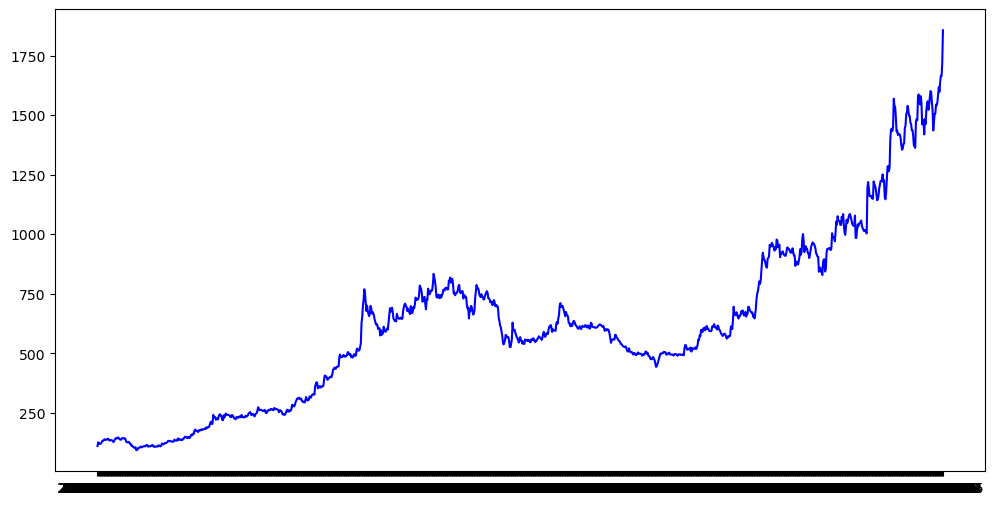

In [217]:
import matplotlib.pyplot as plt

# Combine historical and predicted data for visualization
combined_data = pd.concat([data[['Date', 'Close']], future_data[['Date', 'Predicted_Close']]])
combined_data.set_index('Date', inplace=True)

# Plot historical and predicted prices
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Close'], label='Historical Prices', color='blue')
plt.plot(future_data['Date'], future_data['Predicted_Close'], label='Predicted Prices', color='green')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction with Sentiment Integration')
plt.legend()
plt.show()


TypeError: tz must be string or tzinfo subclass.

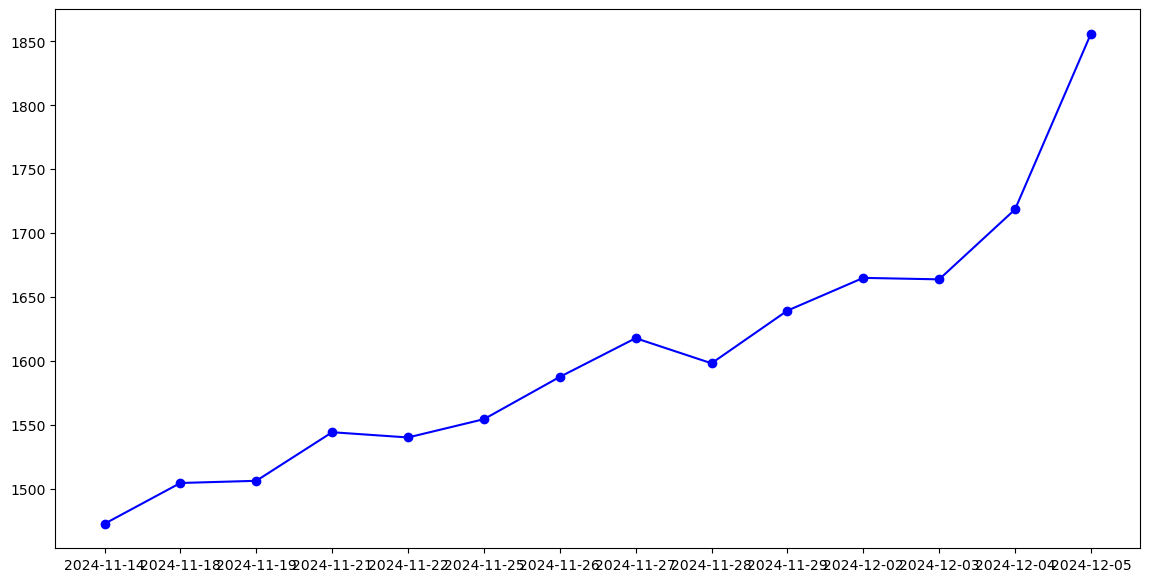

In [231]:
import matplotlib.pyplot as plt

# Get the last two weeks of actual data (14 days)
last_two_weeks = data.tail(14)  # Adjust this if your data doesn't have daily entries

# Combine the last two weeks of actual data with the predicted 5 days' data
combined_data = pd.concat([last_two_weeks[['Date', 'Close']], future_data[['Date', 'Predicted_Close']]])

# Ensure that the 'Date' column is properly formatted without timezones
combined_data['Date'] = pd.to_datetime(combined_data['Date']).dt.tz_localize(None)

# Set 'Date' as the index for easier plotting
combined_data.set_index('Date', inplace=True)

# Create the plot
plt.figure(figsize=(14, 7))

# Plot the actual stock prices for the last two weeks
plt.plot(last_two_weeks['Date'], last_two_weeks['Close'], label='Actual Prices (Last 2 Weeks)', color='blue', marker='o')

# Plot the predicted stock prices for the next 5 days
plt.plot(future_data['Date'], future_data['Predicted_Close'], label='Predicted Prices (Next 5 Days)', color='green', marker='x')

# Add title and labels
plt.title('Stock Price Prediction (Last 2 Weeks and Next 5 Days)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Stock Price', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)

# Display the legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()




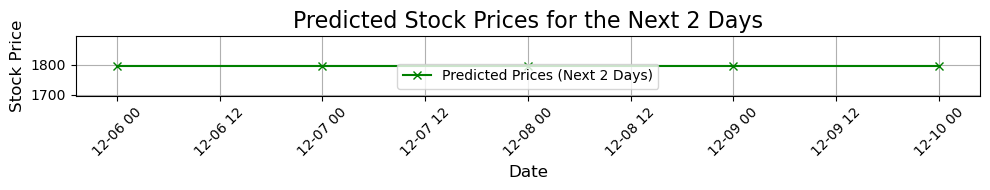

In [232]:
import matplotlib.pyplot as plt

# Plot the predicted stock prices for the next 5 days (green line)
plt.figure(figsize=(10, 2))

plt.plot(future_data['Date'], future_data['Predicted_Close'], label='Predicted Prices (Next 2 Days)', color='green', marker='x')

# Add title and labels
plt.title('Predicted Stock Prices for the Next 2 Days', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Stock Price', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)

# Display the legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


NaN values found in features. Handling them...
Mean Squared Error (MSE): 31.26
Mean Absolute Error (MAE): 2.85
R-squared (R²): 1.00


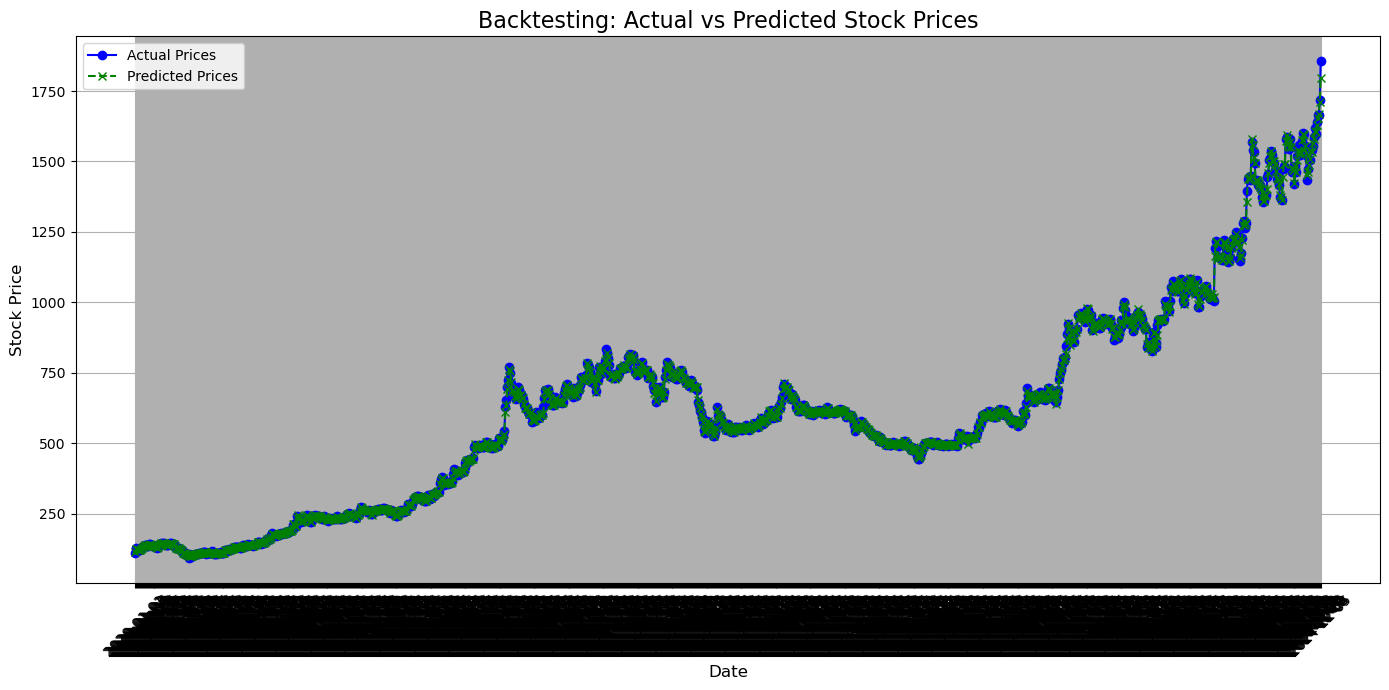

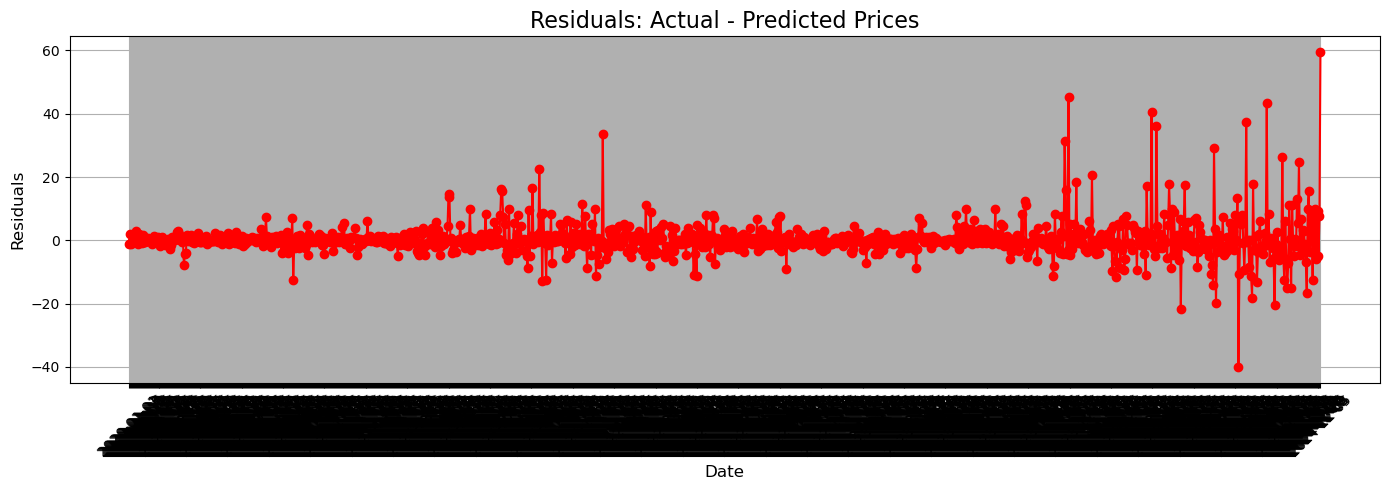

In [221]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Check and handle missing values in X_test
if X_test.isnull().values.any():
    print("NaN values found in features. Handling them...")
    X_test = X_test.fillna(X_test.mean())  # Impute missing values with column means

# Check and handle missing values in y_test
if y_test.isnull().values.any():
    print("NaN values found in target variable. Handling them...")
    y_test = y_test.dropna()  # Drop rows with missing target values
    X_test = X_test.loc[y_test.index]  # Align X_test with y_test

# Predict stock prices using the model
y_pred = rf_model.predict(X_test)

# Evaluate performance
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R²): {r2:.2f}")

# Visualize actual vs predicted prices
plt.figure(figsize=(14, 7))
plt.plot(data['Date'], y_test, label='Actual Prices', color='blue', linestyle='-', marker='o')
plt.plot(data['Date'], y_pred, label='Predicted Prices', color='green', linestyle='--', marker='x')
plt.title('Backtesting: Actual vs Predicted Stock Prices', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Stock Price', fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Plot residuals (Actual - Predicted)
residuals = y_test - y_pred
plt.figure(figsize=(14, 5))
plt.plot(data['Date'], residuals, label='Residuals', color='red', linestyle='-', marker='o')
plt.title('Residuals: Actual - Predicted Prices', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Residuals', fontsize=12)
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()



In [225]:
# Ensure y_test and y_pred are of the same length by excluding the first value
y_test_direction = np.sign(y_test[1:].values - y_test[:-1].values)  # Actual direction of stock prices
y_pred_direction = np.sign(y_pred[1:] - y_pred[:-1])  # Predicted direction (up/down)

# Calculate accuracy of direction prediction
accuracy = np.sum(y_pred_direction == y_test_direction) / len(y_test_direction)

print(f"Direction Prediction Accuracy: {accuracy * 100:.2f}%")



Direction Prediction Accuracy: 87.87%


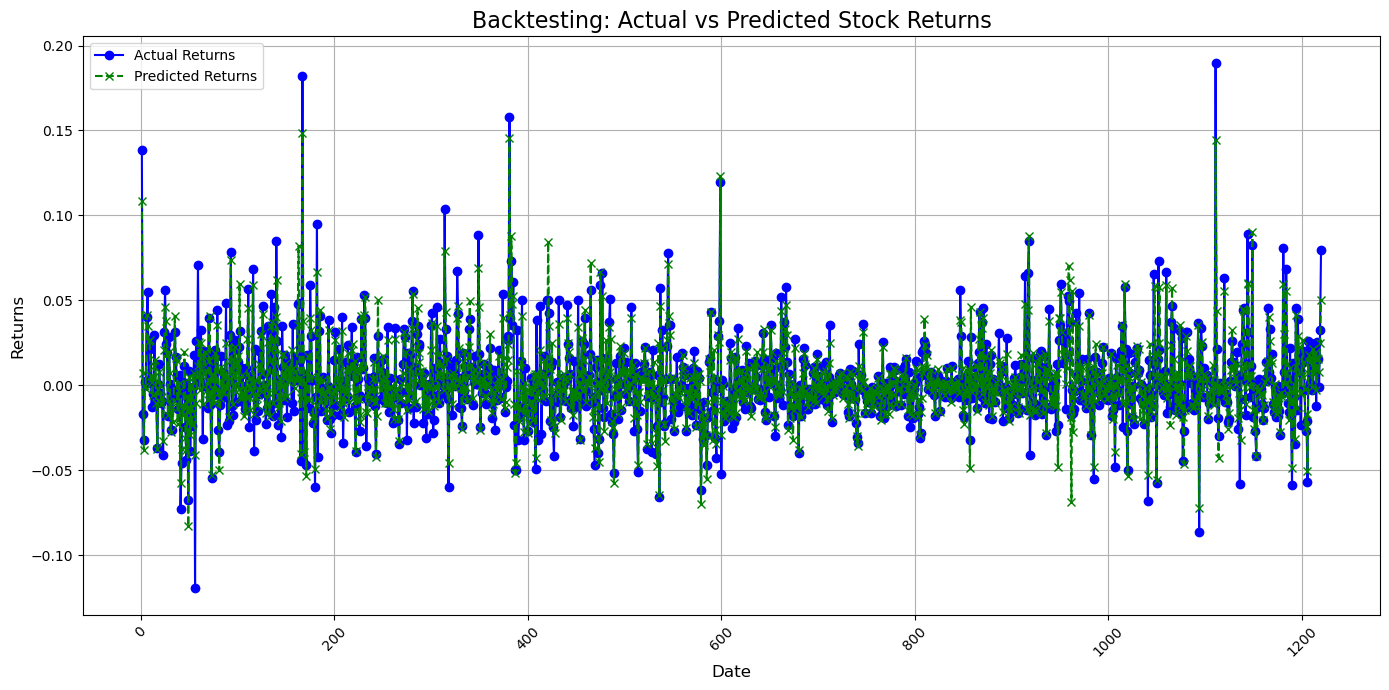

In [227]:
# Calculate daily returns for actual and predicted prices
y_test_returns = y_test.pct_change().dropna()
y_pred_returns = pd.Series(y_pred).pct_change().dropna()

# Plot actual vs predicted returns
plt.figure(figsize=(14, 7))
plt.plot(y_test_returns, label='Actual Returns', color='blue', linestyle='-', marker='o')
plt.plot(y_pred_returns, label='Predicted Returns', color='green', linestyle='--', marker='x')

plt.title('Backtesting: Actual vs Predicted Stock Returns', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Returns', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


C:\Users\sahoo\AppData\Local\Temp\ipykernel_18456\3311727486.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data.corr()


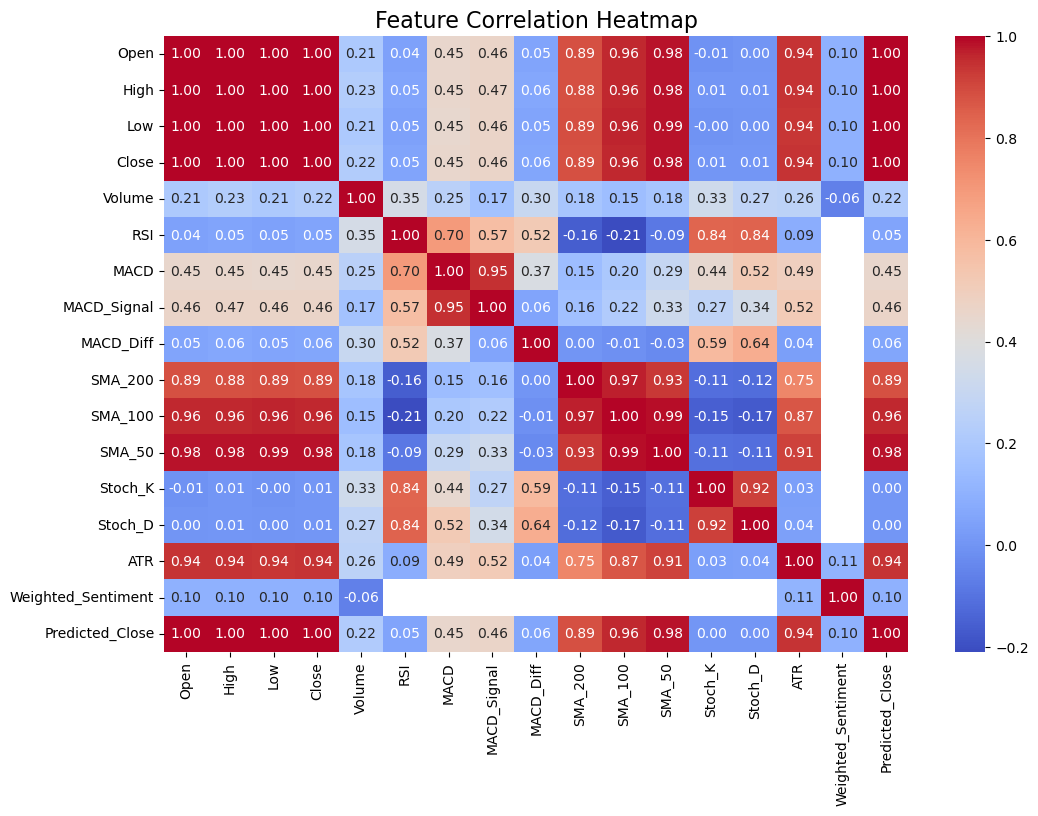

In [228]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate correlation matrix
correlation_matrix = data.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Feature Correlation Heatmap', fontsize=16)
plt.show()
